In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import itertools
import h5py
import keras

Using TensorFlow backend.


In [2]:
# Split a song into multiple songs using overlapping windows
def splitsongs(X, y, window=0.1, overlap=0.5):
    temp_X = []
    temp_y = []
    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)
    return np.array(temp_X), np.array(temp_y)

In [3]:
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft, hop_length=hop_length)[:,:,np.newaxis]
    # Map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [4]:
def read_data(src_dir, genres, song_samples, spec_format, debug=True):
    arr_specs = []
    arr_genres = []
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                # Convert to dataset of melspectograms
                signals, y = splitsongs(signal, genres[x])
                # Convert to "spec" representation
                specs = spec_format(signals)
                # Save
                arr_genres.extend(y)
                arr_specs.extend(specs)
    return np.array(arr_specs), np.array(arr_genres)

In [5]:
# Parameters
gtzan_dir = 'data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
#X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)

In [6]:
X = np.load('x_gtzan_npy.npy')
y = np.load('y_gtzan_npy.npy')

In [7]:
# One hot encoding of labels
from keras.utils import to_categorical
y = to_categorical(y)

In [8]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

(19000, 128, 129, 3)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.3, random_state=42, stratify = y)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 3) (5700, 128, 129, 3) (13300, 10) (5700, 10)


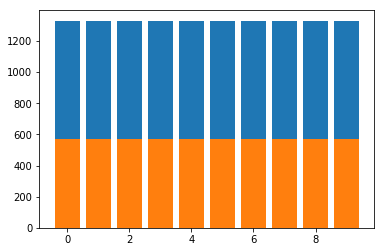

In [11]:
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)
values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [13]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(256, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))
    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False
    return model

model = cnn_vgg16(input_shape, num_genres, 5)
model.summary()

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 129, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 129, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 129, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
hist = model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/20
13300/13300 [==============================] - 53s 4ms/step - loss: 2.1425 - acc: 0.2608 - val_loss: 1.7137 - val_acc: 0.3768
Epoch 2/20
13300/13300 [==============================] - 44s 3ms/step - loss: 1.6000 - acc: 0.4241 - val_loss: 1.3866 - val_acc: 0.4991
Epoch 3/20
13300/13300 [==============================] - 44s 3ms/step - loss: 1.2948 - acc: 0.5419 - val_loss: 1.1446 - val_acc: 0.5926
Epoch 4/20
13300/13300 [==============================] - 44s 3ms/step - loss: 1.1053 - acc: 0.6072 - val_loss: 0.9843 - val_acc: 0.6432
Epoch 5/20
13300/13300 [==============================] - 44s 3ms/step - loss: 0.9725 - acc: 0.6618 - val_loss: 0.8388 - val_acc: 0.7016
Epoch 6/20
13300/13300 [==============================] - 43s 3ms/step - loss: 0.8700 - acc: 0.7013 - val_loss: 0.8439 - val_acc: 0.7070
Epoch 7/20
13300/13300 [==============================] - 43s 3ms/step - loss: 0.7992 - acc: 0.7236 - val_loss: 0.9174 - val_acc:

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = ", round(score[0], 3)," and val_acc = ", round(score[1], 3))

val_loss =  0.416  and val_acc =  0.878


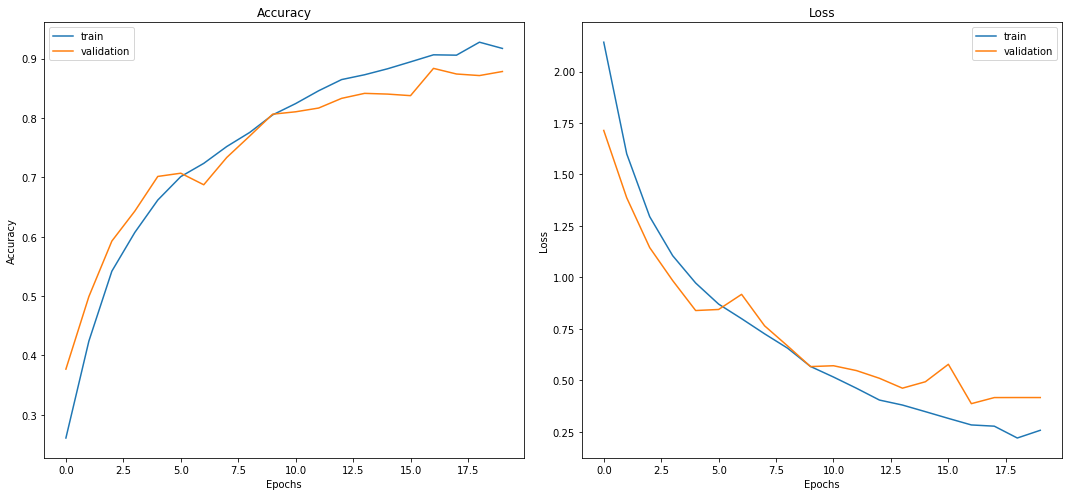

In [16]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [18]:
preds = np.argmax(model.predict(X_test), axis=1)
y_orig = np.argmax(y_test, axis=1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


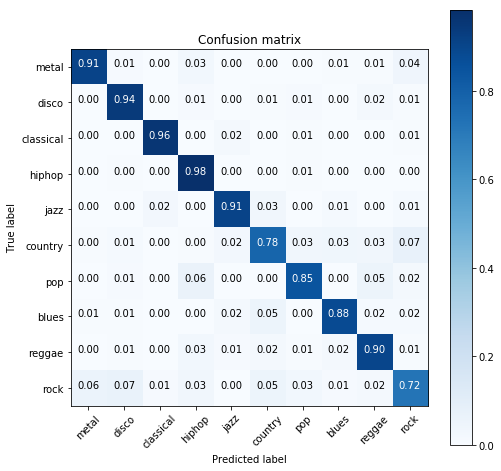

In [19]:
from collections import OrderedDict
keys = OrderedDict(sorted(genres.items(), key = lambda t: t[1])).keys()
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

In [20]:
# Save model
model.save("model/cnn_vgg16.h5")